In [1]:
import gym
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import namedtuple, deque

#### Буфер в которым хранятся данные для experience replay:

In [2]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
        self.transition = namedtuple('Transition', ('states', 'actions', 'next_states', 'rewards', 'dones'))

    def push(self, *args):
        self.memory.append(self.transition(*args))

    def sample(self, batch_size):
        sample = random.sample(self.memory, batch_size)
        batch = self.transition(*zip(*sample))
        self.states = torch.tensor(batch.states).float()
        self.actions = torch.tensor(batch.actions).float()
        self.next_states = torch.tensor(batch.next_states).float()
        self.rewards = torch.tensor(batch.rewards).float()
        self.dones = torch.tensor(batch.dones).float()

    def __len__(self):
        return len(self.memory)

#### Класс Actor, отвечающий за политику агента(предсказывает действие в интервале (-1, 1)):

In [3]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.tanh(x)

#### Класс Critic в котором определены два критика из предсказания которых будем брать минимум:

In [4]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1_Q1 = nn.Linear(state_dim, 256)
        self.fc2_Q1 = nn.Linear(256 + action_dim, 256)
        self.fc3_Q1 = nn.Linear(256, 1)

        self.fc1_Q2 = nn.Linear(state_dim, 256)
        self.fc2_Q2 = nn.Linear(256 + action_dim, 256)
        self.fc3_Q2 = nn.Linear(256, 1)

    def forward(self, x, a):
        x1 = F.relu(self.fc1_Q1(x))
        x1 = F.relu(self.fc2_Q1(torch.cat([x1, a], dim=1)))
        x1 = self.fc3_Q1(x1)

        x2 = F.relu(self.fc1_Q2(x))
        x2 = F.relu(self.fc2_Q2(torch.cat([x2, a], dim=1)))
        x2 = self.fc3_Q2(x2)
        return x1, x2

    def Q1_froward(self, x, a):
        x = F.relu(self.fc1_Q1(x))
        x = F.relu(self.fc2_Q1(torch.cat([x, a], dim=1)))
        x = self.fc3_Q1(x)
        return x


#### Шум, сгенерированный Ornstein-Uhlenbeck Process, добавляем к действиям для исследования среды:

In [5]:
class Noise:
    def __init__(self, action_dim, mu=0.0, theta=0.15, sigma=0.15):
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.action_dim = 1
        self.state = self.mu * np.ones(self.action_dim)

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

#### Класс TD3 реализующий алгоритм:

In [6]:
class TD3:
    def __init__(self, env, eps, batch_size, buffer_size, lr, gamma, tau):

        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.low = env.action_space.low[0]
        self.high = env.action_space.high[0]

        self.gamma = gamma
        self.eps = eps
        self.tau = tau

        self.noise_actor = 0.2
        self.noise_clip = 0.5
        self.updates = 0

        self.buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size
        self.noise = Noise(self.action_dim)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.actor = Actor(self.state_dim, self.action_dim).to(self.device).apply(self.init_weights)
        self.critic = Critic(self.state_dim, self.action_dim).to(self.device).apply(self.init_weights)

        self.actor_target = Actor(self.state_dim, self.action_dim).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())

        self.critic_target = Critic(self.state_dim, self.action_dim).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        self.actor_optim = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr)

    @staticmethod        
    def init_weights(layer):
        if type(layer) == nn.Linear:
            nn.init.xavier_normal_(layer.weight)

    @staticmethod
    def soft_update(target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

    def update(self):
        if len(self.buffer) < self.batch_size:
            return

        self.buffer.sample(self.batch_size)
        self.updates += 1

        with torch.no_grad():
            noise_next_a = (torch.randn_like(self.buffer.actions) * self.noise_actor).clamp(-self.noise_clip, self.noise_clip)
            next_actions = (self.actor_target(self.buffer.next_states) + noise_next_a).clamp(self.low, self.high)
            Q1_target, Q2_target = self.critic_target(self.buffer.next_states, next_actions)
            Q_target = torch.min(Q1_target, Q2_target)
            Q_next = self.buffer.rewards.unsqueeze(1) + self.gamma * Q_target * (1 - self.buffer.dones.unsqueeze(1))

        Q1, Q2 = self.critic(self.buffer.states, self.buffer.actions)
        L_Q1, L_Q2 = F.smooth_l1_loss(Q1, Q_next), F.smooth_l1_loss(Q2, Q_next)

        self.critic_optimizer.zero_grad()
        (L_Q1 + L_Q2).backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 0.7)
        self.critic_optimizer.step()

        if self.updates == 2:

            self.updates = 0
            L_actor = -self.critic.Q1_froward(self.buffer.states, self.actor(self.buffer.states)).mean()

            self.actor_optim.zero_grad()
            L_actor.backward()
            torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 0.7)
            self.actor_optim.step()

            self.soft_update(self.actor_target, self.actor, self.tau)
            self.soft_update(self.critic_target, self.critic, self.tau)

    def act(self, state):
        state = torch.tensor(state).float().unsqueeze(0)
        with torch.no_grad():
            action = torch.clamp(self.actor(state).view(-1) + torch.tensor(self.eps * self.noise.noise()), self.low, self.high)
        return action.numpy()

#### Создаем среду и агента: 

In [9]:
env = gym.make('BipedalWalker-v2')
agent = TD3(env=env, eps=1.0, batch_size=256, buffer_size=int(1e5), lr=5e-4, gamma=0.95, tau=0.005)

#### Обучение:

In [10]:
rewards = []
for i in range(1000):
    state = env.reset()
    step, total_reward, done = 0, 0, False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        agent.buffer.push(state, action, next_state, reward, done)
        agent.update()
        state = next_state
        step += 1
    agent.eps *= 0.95
    rewards.append(total_reward)
    print(f'{i+1})Reward: {total_reward} | Steps: {step} Mean 100: {np.mean(rewards[-100:])} | Max: {np.max(rewards)}')

1)Reward: -104.06160831169946 | Steps: 69 Mean 100: -104.06160831169946 | Max: -104.06160831169946
2)Reward: -111.97688508653775 | Steps: 71 Mean 100: -108.01924669911861 | Max: -104.06160831169946
3)Reward: -103.45890746926186 | Steps: 87 Mean 100: -106.4991336224997 | Max: -103.45890746926186
4)Reward: -115.00282937342304 | Steps: 48 Mean 100: -108.62505756023053 | Max: -103.45890746926186
5)Reward: -98.13315240262756 | Steps: 61 Mean 100: -106.52667652870994 | Max: -98.13315240262756
6)Reward: -114.27914050910267 | Steps: 65 Mean 100: -107.8187538587754 | Max: -98.13315240262756
7)Reward: -111.08001303454253 | Steps: 54 Mean 100: -108.28464802674213 | Max: -98.13315240262756
8)Reward: -106.86028459327007 | Steps: 69 Mean 100: -108.10660259755812 | Max: -98.13315240262756
9)Reward: -141.4504560669263 | Steps: 634 Mean 100: -111.81147520526571 | Max: -98.13315240262756
10)Reward: -123.70457506549357 | Steps: 93 Mean 100: -113.00078519128849 | Max: -98.13315240262756
11)Reward: -104.41

#### Тестирование агента в новой среде на 100 эпизодах:

In [14]:
class Test:
    def __init__(self, agent, rewards, test_episodes):
        self.rewards = rewards
        self.test_episodes = test_episodes
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = Actor(env.observation_space.shape[0], env.action_space.shape[0])
        self.model.load_state_dict(agent.actor.state_dict())
        self.model.to(self.device)
        self.run()
        
    def act(self, state):
        with torch.no_grad():
            action = np.clip(self.model(state).view(-1), -1, 1)
        return action.numpy()

    def run(self):
        env = gym.make('BipedalWalker-v2')
        rewards = []
        for i in range(self.test_episodes):
            state = env.reset()
            total_reward = 0
            done = False
            while not done:
                action = self.act(torch.tensor(state, dtype = torch.float).unsqueeze(0))
                next_state, reward, done, _ = env.step(action)
                total_reward += reward
                state = next_state
            rewards.append(total_reward)
        self.mean_rewards = np.mean(rewards)
        self.test_rewards = rewards

    def plot(self):
        plt.figure(figsize=(16, 24))
        ax1 = plt.subplot(421)
        ax2 = plt.subplot(422)
        ax1.plot(np.arange(0, len(self.rewards)), self.rewards, label=f'rewards')
        ax1.set_title(f'Train agent')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Reward')
        ax1.legend()

        ax2.plot(np.arange(0, len(self.test_rewards)), self.test_rewards, label=f'rewards')
        ax2.axhline(y=self.mean_rewards, color='r', linestyle='--', label=f'mean reward: {self.mean_rewards :.2f}')
        ax2.set_title(f'Test agent')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Reward')
        ax2.legend()
        plt.show()

#### Результаты: 

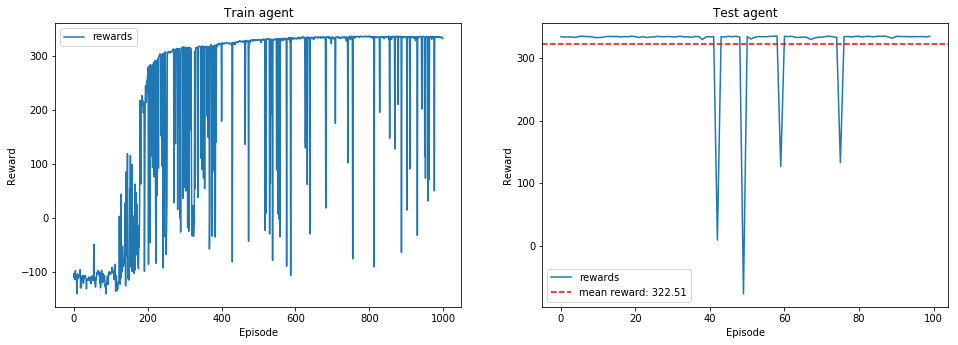

In [17]:
Test(agent, rewards, 100).plot()